# Prediction of Molecular Pathways and Key Mutations

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/07_example_mutationprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/06_example_mutationprediction.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## About this demo
Prediction of molecular pathways and key mutations directly from Haematoxylin and Eosin stained histology images can help bypass additional genetic (e.g., polymerase chain reaction or PCR) or immunohistochemistry (IHC) testing, which can therefore save both money and time.  

In this example notebook, we show how you can use pretrained models to do reproduce the results obtained by [Bilal _et al_](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00180-1/fulltext). Here, the _IDaRS_ pipeline utilises a two-stage approach:

- Patch-level tumour segmentation
- Patch-level WSI prediction

In step 1, we use a pretrained tumour segmentation model to identify potentially diagnositc areas. In step 2, we make a task-specific prediction for each tumour patch. In TIAToolbox, we include models that are capable of predicting:

- Microsatellite instability (MSI)
- Hypermutation density
- Chromosomal instability
- CpG island methylator phenotype (CIMP)-high prediction
- BRAF mutation
- TP53 mutation

## Available models
In line with the above description, in TIAToolbox, we provide the following pretrained models used as part of the [original publication](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00180-1/fulltext):

- Tumour segmentation
    - `resnet18-idars-tumour`
- Task specific prediction
    - MSI
        - `resnet34-idars-msi-fold1`
        - `resnet34-idars-msi-fold2`
        - `resnet34-idars-msi-fold3`
        - `resnet34-idars-msi-fold4`
    - Hypermutation density
        - `resnet34-idars-hm-fold1`
        - `resnet34-idars-hm-fold2`
        - `resnet34-idars-hm-fold3`
        - `resnet34-idars-hm-fold4`
    - Chromosomal instability
        - `resnet34-idars-cin-fold1`
        - `resnet34-idars-cin-fold2`
        - `resnet34-idars-cin-fold3`
        - `resnet34-idars-cin-fold4`
    - CpG island methylator phenotype (CIMP)-high prediction
        - `resnet34-idars-cimp-fold1`
        - `resnet34-idars-cimp-fold2`
        - `resnet34-idars-cimp-fold3`
        - `resnet34-idars-cimp-fold4`
    - BRAF mutation
        - `resnet34-idars-braf-fold1`
        - `resnet34-idars-braf-fold2`
        - `resnet34-idars-braf-fold3`
        - `resnet34-idars-braf-fold4`
    - TP53 mutation
        - `resnet34-idars-tp53-fold1`
        - `resnet34-idars-tp53-fold2`
        - `resnet34-idars-tp53-fold3`
        - `resnet34-idars-tp53-fold4`

As can be seen, for the prediction tasks, we supply the models on each fold, in line with the paper.

### Setting up the environment

You can skip the following cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [1]:
# !apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
# !pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@example-mutation-prediction | tail --line 1 
import os
os.sys.path.append('/home/tialab-dang/local/project/tiatoolbox')

ON_GPU = False
print('Installation is done.')

Installation is done.


**[optional]**: if you are running this example notebook on your system and it is equipped with a Cuda enabled GPU, you can run the following cell to install Cuda enabled version of the torch package to utilize GPU computation and speed up the TIAToolbox models.

In [3]:
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html


### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [2]:
from tiatoolbox.models.controller.patch_predictor import CNNPatchPredictor
from tiatoolbox.utils.misc import imwrite
from tiatoolbox.wsicore.wsireader import get_wsireader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

mpl.rcParams['figure.dpi'] = 250 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a whole slide image of cancerous colon tissue to highlight how the pipeline works. 
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 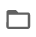

In [4]:
import requests

wsi_file_name = "sample_wsi.svs"
print('Download has started. Please wait...')

# Downloading sample TCGA whole-slide image
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs")
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

print('Download is complete.')

Download has started. Please wait...
Download is complete.


## Tumour segmentation using TIAToolbox pretrained models
In this section, we will display patch-level tumour segmentation results using a pretrained model used in the original paper by Bilal _et al_. In particular, this model is a ResNet model with 18 layers (resnet18). A prediction is made for each input patch, which denotes the probability of being tumour. 

> More information on the model and the dataset used for training can be found [here](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(21)00180-1/fulltext) (_Bilal et al., "Development and validation of a weakly supervised deep learning framework to predict the status of molecular pathways and key mutations in colorectal cancer from routine histology images: a retrospective study"_)

In line with the patch prediction model provided in `tiatoolbox`, the tumour segmentation model can be applied to input patches, large images tiles or whole-slide images. In order to replicate the original pipeline, we choose to process a sample whole-slide image.

In [5]:
tumour_predictor = CNNPatchPredictor(
    pretrained_model='resnet18-idars-tumour',
    batch_size=64,
    num_loader_workers=8)

tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/target.jpg
Save to /home/tialab-dang/.tiatoolbox/idars_target.jpg


|2021-11-02|23:19:18.989| [WARNING] /home/tialab-dang/local/project/tiatoolbox/tiatoolbox/wsicore/wsireader.py:306: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."



Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet18-idars-tumour.pth
Save to /home/tialab-dang/.tiatoolbox/models/resnet18-idars-tumour.pth


  0%|                                                    | 0/67 [00:00<?, ?it/s]|2021-11-02|23:19:39.565| [WARNING] /home/tialab-dang/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()

|2021-11-02|23:19:39.573| [WARNING] /home/tialab-dang/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. 

As can be seen above, with just a few lines of code we are capable of performing tumour segmentation on whole-slide images. If running the prediction like we did above, then the default parameters for `patch_shape`, `stride_shape` and `resolution` will be used. Here, `patch_shape`, and `resolution` are in line with what was used for training the model, whereas `stride_shape` is set to be equal to the `patch_shape` (no overlap). In particular, the input patch size we used is 512x512 and the processing resolution is 0.5 microns per pixel (~20x objective magnification). 

If you want to change the default parameters, you will need to define this using `IOPatchPredictorConfig`. For example, you may want to run with 50% overlap between neighbouring patches. Therefore, you would define:

```
wsi_ioconfig = IOSegmentorConfig(
    input_resolutions=[{'units': 'mpp', 'resolution': 0.5}],
    patch_input_shape=[512, 512],
    stride_shape=[256, 256],
)
```

Then, you would add this in the `predict` method as follows:

```
tumour_output = tumour_predictor.predict(
    imgs=[wsi_file_name],
    mode='wsi',
    return_probabilities=True,
    on_gpu=True
    ioconfig=wsi_ioconfig)
```

Below, we show how to merge the output predictions to form a 2-dimensional prediction map, denoting areas predicted as tumour. This prediction map is used in the second step of the pipeline, where we use only patches containing tumour.

In [14]:

overview_resolution = 1.25 # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power" # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"

# merge predictions to form a 2-dimensional output at the desired resolution
tumour_mask = tumour_predictor.merge_predictions(wsi_file_name, tumour_output[0], resolution=overview_resolution, units=overview_unit)

# the output map will contain values from 0 to 2. 
# 0: background that is not processed, 1: non-tumour prediction and 2 is tumour predictions
tumour_mask = tumour_mask == 2 # binarise the output
imwrite('tumour_mask.png', tumour_mask.astype('uint8') * 255)

Now that we have merged the prediction, let's visualise the results!

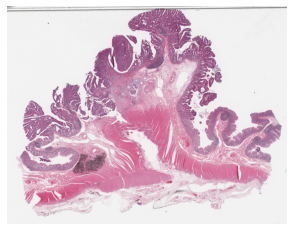

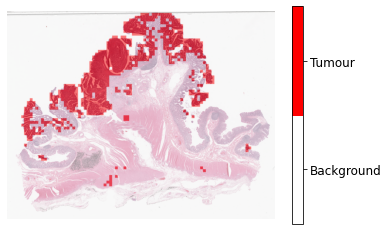

In [15]:
from tiatoolbox.utils.visualization import overlay_patch_prediction

# first read the WSI at a low-resolution. Here, we use the same resolution that was used when merging the patch-level results.
wsi = get_wsireader(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview); plt.axis('off')

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_patch_prediction` function to help generate a color legend
label_dict = {'Background': 0, 'Tumour': 1}
label_color_dict = {}
colors = [[255, 255, 255], [255, 0, 0]]
for class_name, label in label_dict.items():
    label_color_dict[label] = (class_name, np.array(colors[label]))

overlay = overlay_patch_prediction(wsi_overview, tumour_mask, alpha=0.5, label_info=label_color_dict)
plt.show()

## WSI prediction using TIAToolbox pretrained models
Next, we show how one can use a second CNN that takes as input the result obtained from part 1 and gives a prediction for each tumour patch in the input WSI. When conducting the experiments reported in the original paper, 4 fold cross validation was used. Therefore, we supply the weights of each fold for each WSI prediction task. In line with the original paper, all models in the second step are ResNet34.

Near the beginning of the notebook, we mention which prediction tasks we consider. To demonstrate the pipeline, we initially show how we can use the model to predict whether an input WSI is **MSI positive**.

In [16]:
msi_predictor = CNNPatchPredictor(
    pretrained_model='resnet34-idars-msi-fold1',
    batch_size=64,
    num_loader_workers=8)

# we include the obtained tumour mask from stage 1 as an argument so that we only process patches from those regions.
msi_output = msi_predictor.predict(
    imgs=[wsi_file_name], 
    masks=['tumour_mask.png'],
    mode='wsi',
    return_probabilities=True, 
    on_gpu=True) 

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/idars/resnet34-idars-msi-fold1.pth
Save to /home/tialab-dang/.tiatoolbox/models/resnet34-idars-msi-fold1.pth


  0%|                                                    | 0/23 [00:00<?, ?it/s]|2021-11-02|23:30:46.631| [WARNING] /home/tialab-dang/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()

|2021-11-02|23:30:46.636| [WARNING] /home/tialab-dang/anaconda3/envs/tiatoolbox/lib/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. 

In [20]:
# merge predictions to form a 2-dimensional output at the desired resolution
msi_pmap = msi_predictor.merge_predictions(wsi_file_name, msi_output[0], resolution=overview_resolution, units=overview_unit, return_probmap=True)
msi_pmap = msi_pmap[..., 1] # consider only the positive class (probability of MSI in this case)

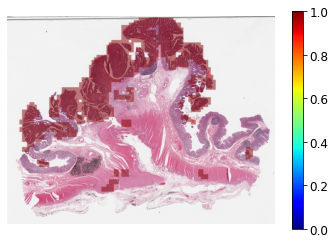

In [23]:
from tiatoolbox.utils.visualization import overlay_patch_probmap

# [Overlay map creation]
overlay = overlay_patch_probmap(wsi_overview, msi_pmap, alpha=0.5, min_val=0.4)